In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as io

# Spectral Measurements

## Loading data

In [2]:
spectral_dataframe = pd.read_excel("./data/04-b_ColorChart.xlsx", sheet_name="Spectral Measurements", index_col = 0).T
observer_dataframe = pd.read_csv('data/CIE1931_CMF.csv', index_col = 0)

d65_illuminance_dataframe = pd.read_csv('data/D65.csv', index_col = 0)
d65_XYZ_references = np.array([0.9504, 1.0, 1.0888]).reshape((3, 1))

a_illuminance_dataframe = pd.read_csv('data/A.csv', index_col = 0)
a_XYZ_references = np.array([1.0985, 1.0, 0.3558]).reshape((3, 1))

## Code to compute LAB dataframes

In [3]:
def function(t):
    return  t ** (1 / 3) if t > (6 / 29) ** 3 else (1 / 3) * (6 / 29) ** 2 * t + 4 / 29
    
def compute_LAB(XYZ_value):
    X, Y, Z = XYZ_value
    
    L = 116 * function(Y) - 16
    a = 500 * (function(X) - function(Y))
    b = 200 * (function(Y) - function(Z))
    
    return (L, a, b)

def compute_XYZ_values(spectral_dataframe, illuminance_dataframe, observer_dataframe):
    x, y, z = np.moveaxis(observer_dataframe.to_numpy(), 1, 0)
    illuminance = illuminance_dataframe.to_numpy().reshape(y.shape)
    
    N = np.sum(illuminance * y)
    
    XYZ_values = []
    
    for spectrum_name in spectral_dataframe:
        spectrum = spectral_dataframe[spectrum_name].to_numpy()
        
        X = (1 / N) * np.sum(illuminance * x * spectrum)
        Y = (1 / N) * np.sum(illuminance * y * spectrum)
        Z = (1 / N) * np.sum(illuminance * z * spectrum)
        
        XYZ_values.append([X, Y, Z])
        
    return np.array(XYZ_values)

def compute_LAB_values(spectral_dataframe, illuminance_dataframe, observer_dataframe, XYZ_references):
    XYZ_values = compute_XYZ_values(spectral_dataframe, illuminance_dataframe, observer_dataframe)
    XYZ_values = (XYZ_values.T / XYZ_references).T
    return np.apply_along_axis(compute_LAB, 1, XYZ_values)

def get_LAB_dataframe(spectral_dataframe, illuminance_dataframe, observer_dataframe, XYZ_references):
    XYZ_values = compute_LAB_values(spectral_dataframe, illuminance_dataframe, observer_dataframe, XYZ_references)
    return pd.DataFrame(XYZ_values, index = spectral_dataframe.T.index, columns =  ['L', 'a', 'b'])

In [4]:
d65_LAB_dataframe = get_LAB_dataframe(spectral_dataframe, d65_illuminance_dataframe, observer_dataframe, d65_XYZ_references)
a_LAB_dataframe = get_LAB_dataframe(spectral_dataframe, a_illuminance_dataframe, observer_dataframe, a_XYZ_references)

print("When using D65 illuminant {} colors have the 'a' channel > 20.".format(np.sum(d65_LAB_dataframe['a'] > 20)))
print("When using A illuminant {} colors have the 'a' channel > 20.".format(np.sum(a_LAB_dataframe['a'] > 20)))

d65_LAB_dataframe.to_csv('output/D65_LAB.csv')
a_LAB_dataframe.to_csv('output/A_LAB.csv')

When using D65 illuminant 24 colors have the 'a' channel > 20.
When using A illuminant 22 colors have the 'a' channel > 20.


The difference of number of color having the 'a' composant higher than 20 between Lab values computed from D65 illuminant and A illuminant could be explained by the fact that those 2 illuminants does not try to represent the same white reference. Indeed, the D65 illumant tries to represent the natural light and the A illuminant tries to represent the light emitted by a light bulb.

## Color conversion

In [5]:
def compute_SRGB(XYZ_value):
    XYZ_to_sRGB_mat  = np.array([[3.2406, -1.5372, -0.4986], [-0.9689, 1.8758, 0.0415], [0.0557, -0.2040, 1.0570]])
    return np.clip(np.dot(XYZ_to_sRGB_mat, XYZ_value) * 255, 0, 255).astype(np.uint8)

def create_image(sprectral_dataframe, spectrum_names, illuminance_dataframe, observer_dataframe, A_illuminant):
    spectrum_list = spectral_dataframe[spectrum_names]  
    XYZ_values = compute_XYZ_values(spectrum_list, illuminance_dataframe, observer_dataframe)
    if (A_illuminant):
        XYZ_values = np.dot(np.array([[0.8652435, 0., 0.], [0., 1., 0.], [0., 0., 3.0598005]]), XYZ_values.T).T
    SRGB_values = np.apply_along_axis(compute_SRGB, 1, XYZ_values)
    
    image_width = len(spectrum_names) // 2
    image = np.zeros((200, image_width * 100, 3), dtype = np.uint16)
    
    for SRGB_index in range(len(SRGB_values)):
        col_index = (SRGB_index % image_width) * 100
        row_index = (SRGB_index // image_width) * 100
        
        image[row_index:row_index + 100, col_index:col_index + 100] = SRGB_values[SRGB_index]
    
    return image

def save_image(image, path):
    io.imsave(path, image)

/tmp/ipykernel_8848/3267843679.py:24: UserWarning: output/D65_sRGB_result.tiff is a low contrast image
  io.imsave(path, image)


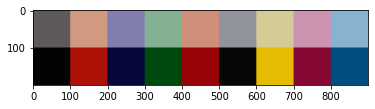

In [6]:
spectrum_names = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                      'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9']

d65_image = create_image(spectral_dataframe, spectrum_names, d65_illuminance_dataframe, observer_dataframe, False)
plt.imshow(d65_image)
save_image(d65_image, 'output/D65_sRGB_result.tiff')

/tmp/ipykernel_8848/3267843679.py:24: UserWarning: output/A_sRGB_result.tiff is a low contrast image
  io.imsave(path, image)


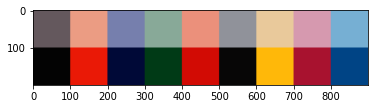

In [7]:
a_image = create_image(spectral_dataframe, spectrum_names, a_illuminance_dataframe, observer_dataframe, True)
plt.imshow(a_image)
save_image(a_image, 'output/A_sRGB_result.tiff')